<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1KerrasUnbalancedData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries & read in file

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full.csv


# Data Exploration

(41188, 21)
No claim 36548
Claim 4640
Claim proportion 11.27%


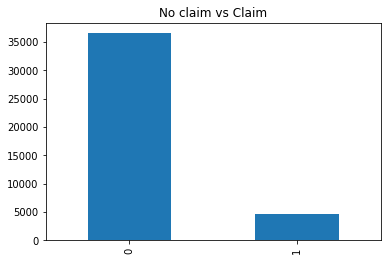

In [5]:
print(df.shape)
df.columns

def percentage(part, whole):
  return 100 * float(part) / float(whole)

df.rename(columns = {'y':'target'}, inplace = True)
df['target'] = df.target.apply(lambda x: 1 if x == "yes" else 0)

no_claim, claim = df.target.value_counts()
print(f'No claim {no_claim}')
print(f'Claim {claim}')
print(f'Claim proportion {round(percentage(claim, claim + no_claim), 2)}%')

df.target.value_counts().plot(kind="bar", title="No claim vs Claim");

## Data preprocessing

In [6]:
row_count = df.shape[0]

for c in df.columns:
  m_count = df[df[c] == -1][c].count()
  if m_count > 0:    
    print(f'{c} - {m_count} ({round(percentage(m_count, row_count), 3)}%) rows missing')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

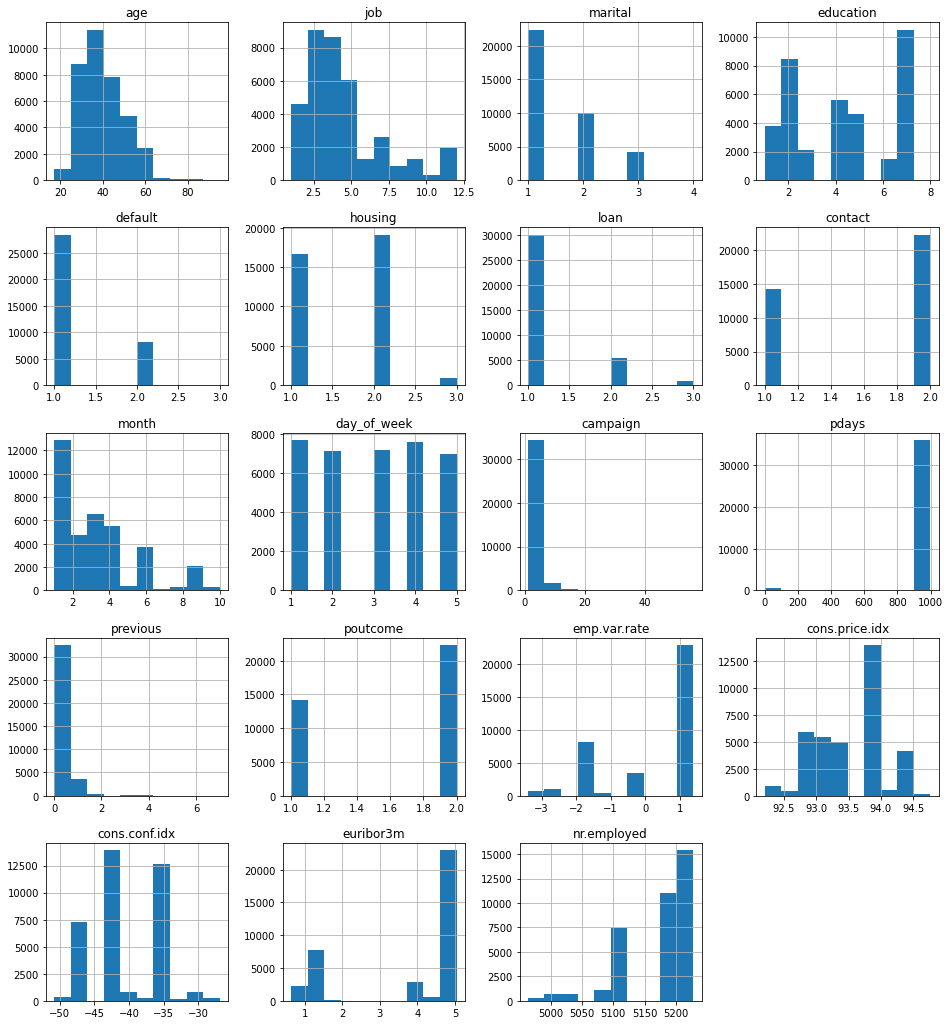

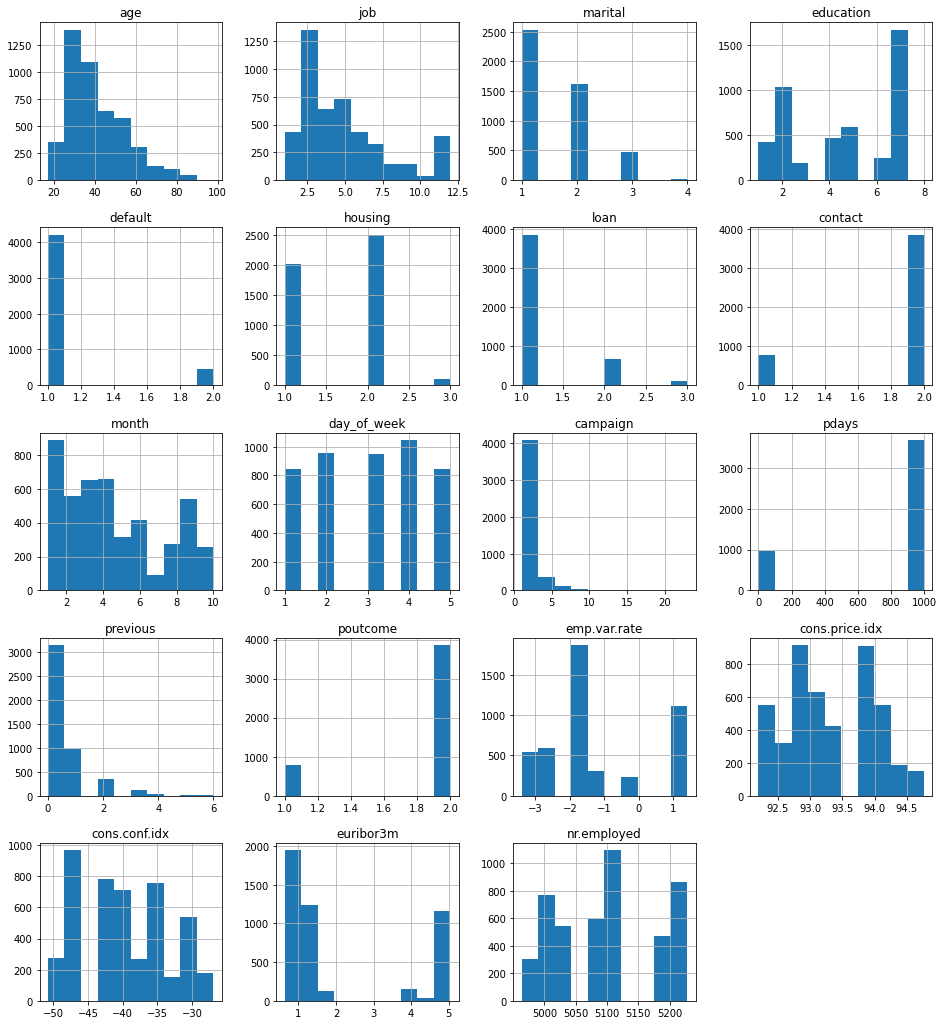

In [7]:
df.info()

df['job'] = pd.factorize(df['job'])[0] + 1
df['marital'] = pd.factorize(df['marital'])[0] + 1
df['education'] = pd.factorize(df['education'])[0] + 1
df['default'] = pd.factorize(df['default'])[0] + 1
df['housing'] = pd.factorize(df['housing'])[0] + 1
df['default'] = pd.factorize(df['default'])[0] + 1
df['loan'] = pd.factorize(df['loan'])[0] + 1
df['contact'] = pd.factorize(df['contact'])[0] + 1
df['month'] = pd.factorize(df['month'])[0] + 1
df['day_of_week'] = pd.factorize(df['day_of_week'])[0] + 1
df['poutcome'] = pd.factorize(df['contact'])[0] + 1

# Should remove - duration as only for benchmark
df = df.drop('duration', 1)

df.groupby('target').hist(figsize = (16,18))

df['previously_contacted'] = df.pdays.apply(lambda x: 0 if x == 999 else 1)
df = df.drop('pdays', 1)

nr.employed            -0.354678
euribor3m              -0.307771
emp.var.rate           -0.298334
cons.price.idx         -0.136211
default                -0.099352
campaign               -0.066357
loan                   -0.005038
housing                 0.009552
day_of_week             0.010051
marital                 0.026302
age                     0.030399
education               0.045721
job                     0.054793
cons.conf.idx           0.054878
poutcome                0.144773
contact                 0.144773
month                   0.183471
previous                0.230181
previously_contacted    0.324877
target                  1.000000
Name: target, dtype: float64


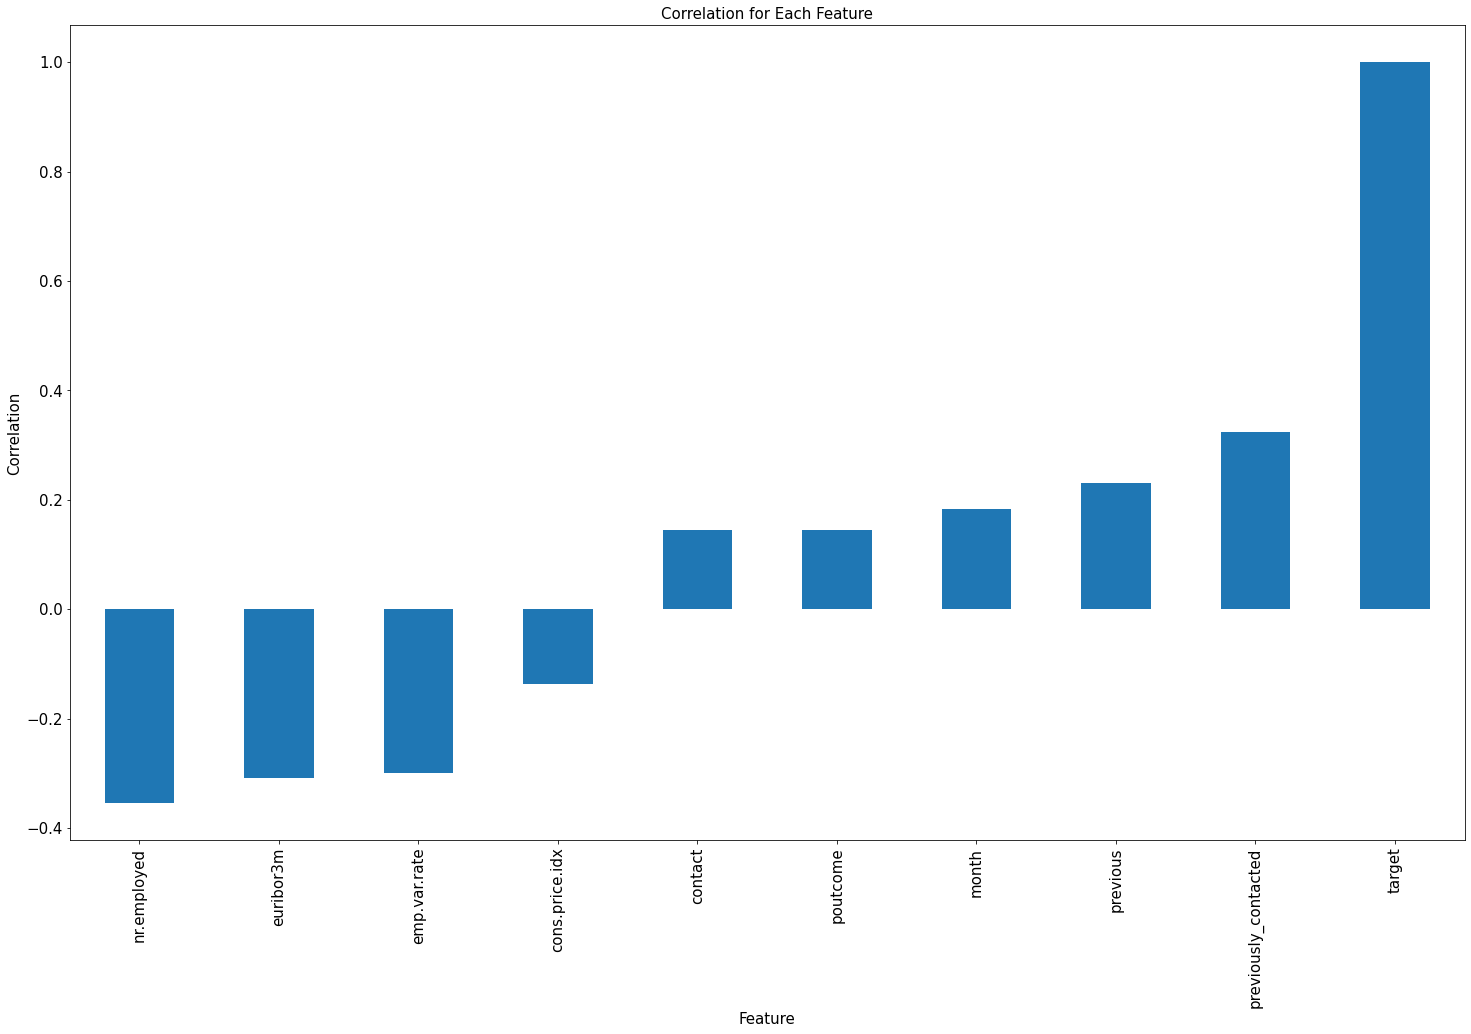

In [8]:
# # Create correlation matrix
std_features_keep = df
corr_matrix = std_features_keep.corr()['target'].sort_values()
print(corr_matrix)
threshold = 0.1

for  i, v in corr_matrix.iteritems():
    if(abs(v) < threshold):
      std_features_keep = std_features_keep.drop(i, axis=1)

# Plot for correlation
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
std_plot = (std_features_keep.corr()['target'].sort_values()).plot(kind="bar",figsize=(25,15))
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Correlation for Each Feature')
plt.show()

## Neural Network

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [10]:
BATCH_SIZE = 2048


import keras
from keras import backend as K
import tensorflow as tf

# 0.01, 0.001, or 0.0001
learning_rate_intial = 0.001
def build_model(train_data,learning_rate,output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
    keras.layers.Dense(
      units=36, 
      activation='relu',
      input_shape=(train_data.shape[-1],)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=1, activation='sigmoid',bias_initializer=output_bias),
  ])

  model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
  )

  return model

# Metrics

In [23]:
from sklearn.metrics import confusion_matrix

def get_cm(labels, predictions, p=0.5):
  tick_labels = ['Y', 'N']
  cm = confusion_matrix(labels, predictions > p)
  print('% right for no: ', cm[0][0]/(cm[0][0] + cm[0][1]))
  print('% right for yes: ', cm[1][1]/(cm[1][1] + cm[1][0]))
  return cm

def plot_cm(labels, predictions, p=0.5):
  get_cm(labels, predictions, p)
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

In [12]:
from sklearn.metrics import f1_score

def print_metrics(model, evaluation_results, predictions):
  for name, value in zip(model.metrics_names, evaluation_results):
    print(name, ': ', value)
  print(f'f1 score: {f1_score(y_test, np.round(y_pred.flatten()))}')
  print()

# Create Model

In [13]:
from sklearn.model_selection import train_test_split

X = std_features_keep.drop(i, axis=1)
y = df['target']

labels = X.columns.values

from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

# Print mean and standard deviation
print("Mean:", round(X[:,0].mean()))
print("Standard deviation:", X[:,0].std())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=RANDOM_SEED)

Mean: 0
Standard deviation: 1.0000000000000002


# Weighted model

In [14]:
no_claim_count, claim_count = np.bincount(df.target)
total_count = len(df.target)

weight_no_claim = ((1 / no_claim_count) * (total_count) / 2.0 )
weight_claim = (((1 / claim_count) * (total_count) / 2.0 )) 
print("no claim:  " + str(weight_no_claim))
print("claim:  " + str(weight_claim))
class_weights = {0: weight_no_claim, 1: weight_claim}

no claim:  0.5634781656999015
claim:  4.438362068965517


In [15]:
initial_bias = np.log([claim/no_claim])
model_weighted = build_model(X_train, learning_rate_intial, initial_bias)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

history_weighted = model_weighted.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping],
    shuffle=True,
    class_weight=class_weights
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
20/20 [==============================] - 5s 78ms/step - loss: 0.8300 - tp: 2099.0000 - fp: 4311.0000 - tn: 30414.0000 - fn: 2304.0000 - accuracy: 0.8309 - precision: 0.3275 - recall: 0.4767 - auc: 0.7446 - val_loss: 0.3462 - val_tp: 68.0000 - val_fp: 64.0000 - val_tn: 1759.0000 - val_fn: 169.0000 - val_accuracy: 0.8869 - val_precision: 0.5152 - val_recall: 0.2869 - val_auc: 0.7602
Epoch 2/100
20/20 [==============================] - 0s 13ms/step - loss: 0.7556 - tp: 2284.0000 - fp: 4322.0000 - tn: 30403.0000 - fn: 2119.0000 - accuracy: 0.8354 - precision: 0.3457 - recall: 0.5187 - auc: 0.7589 - val_loss: 0.3505 - val_tp: 72.0000 - val_fp: 69.0000 - val_tn: 1754.0000 - val_fn: 165.0000 - val_accuracy: 0.8864 - val_precision: 0.5106 - val_recall: 0.3038 - val_auc: 0.7703
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.7186 - tp: 2249.0000 - fp: 4298.0000 - tn: 30427.0000 - fn: 2154.0000 - accuracy: 0.8351 - precision: 0.3435 - recall: 0.5108 - auc:

Evaluation

In [16]:
evaluation_results = model_weighted.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_weighted.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model_weighted, evaluation_results, y_pred)

loss :  0.5328850150108337
tp :  143.0
fp :  265.0
tn :  1558.0
fn :  94.0
accuracy :  0.825728178024292
precision :  0.35049018263816833
recall :  0.6033755540847778
auc :  0.7886672616004944
f1 score: 0.44341085271317826



% right for no:  0.8546352166758091
% right for yes:  0.6033755274261603


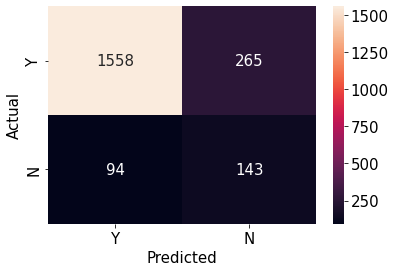

In [17]:
plot_cm(y_test, y_pred)

# Tuning Hyperparamters

In [25]:
max_accuracy_random_forrest = 0
max_index_random_forrest = 0
y_pred_max = 0
range_allowed = np.arange(0.0, 0.001, 0.0001)

for learning_rate in range_allowed:
  model_weighted = build_model(X_train, learning_rate,initial_bias)

  history_weighted = model_weighted.fit(
      X_train,
      y_train,
      batch_size=BATCH_SIZE,
      epochs=20,
      verbose = 0,
      validation_data=(X_test, y_test), 
      callbacks=[early_stopping],
      shuffle=True,
      class_weight=class_weights
  )
  y_pred = model_weighted.predict(X_test, batch_size=BATCH_SIZE)
  print('learning rate:  ' + str(learning_rate))
  get_cm(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


learning rate:  0.0
% right for no:  0.9709270433351618
% right for yes:  0.2742616033755274


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


learning rate:  0.0001
% right for no:  0.9643444871091608
% right for yes:  0.32489451476793246


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


learning rate:  0.0002
% right for no:  0.8705430608886451
% right for yes:  0.5654008438818565


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


learning rate:  0.00030000000000000003
% right for no:  0.8584750411409764
% right for yes:  0.5780590717299579


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


learning rate:  0.0004
% right for no:  0.8562808557323094
% right for yes:  0.5780590717299579


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


learning rate:  0.0005
% right for no:  0.8606692265496434
% right for yes:  0.5738396624472574


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


learning rate:  0.0006000000000000001
% right for no:  0.8535381239714755
% right for yes:  0.5864978902953587


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


learning rate:  0.0007
% right for no:  0.8694459681843115
% right for yes:  0.5654008438818565


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


learning rate:  0.0008
% right for no:  0.8518924849149753
% right for yes:  0.5991561181434599


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


learning rate:  0.0009000000000000001
% right for no:  0.8518924849149753
% right for yes:  0.5907172995780591


In [26]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.7 MB/s 


In [71]:
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras # importing keras

def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(X_train.shape[-1],)))
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))
  # Add next layers
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(10, activation='softmax',name='dense_2'))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  return model
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective="accuracy", # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='dir', # directory to save logs 
project_name='khyperband')

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[stop_early])

Trial 31 Complete [00h 00m 33s]
val_accuracy: 0.9009708762168884

Best val_accuracy So Far: 0.9009708762168884
Total elapsed time: 00h 07m 57s
INFO:tensorflow:Oracle triggered exit


In [74]:
# Build the model with the optimal hyperparameters
best_hp=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
history_weighted = h_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(X_test, y_test), 
    class_weight=class_weights
)
evaluation_results = h_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = h_model.predict(X_test, batch_size=BATCH_SIZE)
plot_cm(y_test, y_pred)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 9)                 0         
                                                                 
 dense_1 (Dense)             (None, 480)               4800      
                                                                 
 dropout_3 (Dropout)         (None, 480)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                4810      
                                                                 
Total params: 9,610
Trainable params: 9,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
20/20 [==============================] - 1s 15ms/step - loss: 0.6199 - accuracy: 0.5923 - val_loss: 0.9062 - val_accuracy: 0.2903
Epoch 2/10
20/20 [=========================

ValueError: ignored

# Architecture

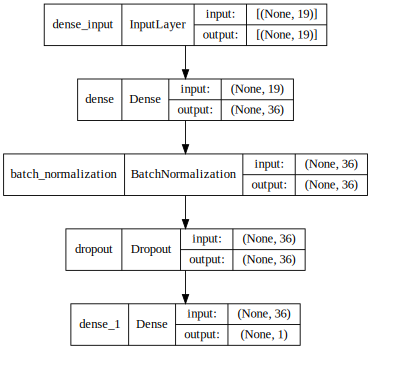

In [ ]:
from IPython.display import SVG
import tensorflow as tf
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_weighted, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))